#### Import Modules

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import Draw, MolFromSmiles
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect

#### Define Functions

In [2]:
def to_fp_ECFP(smi):
    if smi:
        mol = MolFromSmiles(smi)
        if mol is None:
            return None
        return GetMorganFingerprintAsBitVect(mol, 2, 1024)
    
    
def tanimoto_similarity(smi1, smi2):
    fp1, fp2 = None, None
    if smi1 and type(smi1)==str and len(smi1)>0:
        fp1 = to_fp_ECFP(smi1)
    if smi2 and type(smi2)==str and len(smi2)>0:
        fp2 = to_fp_ECFP(smi2)

    if fp1 is not None and fp2 is not None:
        return TanimotoSimilarity(fp1, fp2)
    else:
        return None


def plot_smiles_group(smiles, save_path, n_per_mol=None, img_size=None,
                      descriptions=None, substructure=None):
    kwargs = {}
    kwargs['returnPNG'] = False
    kwargs['useSVG'] = False
    molecules = list(map(MolFromSmiles, smiles))
    if substructure:
        substructure = Chem.MolFromSmiles(substructure)
    draw_options = Draw.MolDrawOptions()
    
    if n_per_mol is not None:
        kwargs['molsPerRow'] = n_per_mol
    if img_size is not None:
        kwargs['subImgSize'] = img_size
    if descriptions is not None:
        kwargs['legends'] = descriptions
    kwargs['mols'] = molecules
    
    if substructure:
        highlights = []
        for mol in molecules:
            match = mol.GetSubstructMatch(substructure)
            atom_highlights = set(match)
            bond_highlights = set()
            for atom_idx in match:
                atom_bonds = mol.GetAtomWithIdx(atom_idx).GetBonds()
                for bond in atom_bonds:
                    if bond.GetBeginAtomIdx() in match and bond.GetEndAtomIdx() in match:
                        bond_highlights.add(bond.GetIdx())
            highlights.append((atom_highlights, bond_highlights))

        kwargs['highlightAtomLists'] = [hl_atoms for hl_atoms, _ in highlights]
        kwargs['highlightBondLists'] = [hl_bonds for _, hl_bonds in highlights]

    kwargs['drawOptions'] = draw_options

    svg_data = Draw.MolsToGridImage(**kwargs)
    svg_data.save(save_path)

#### Define File Path

In [3]:
# save path

save_folder = '/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/mol-interpolation/'

# model path

model_folder1 = 'vaetf1-37'
model_folder2 = 'pvaetf1-15'
model_folder3 = 'ctf1-30'
model_folder4 = 'scavaetf1-15'
model_folder5 = 'pscavaetf1-17'
model_folder = [model_folder1, model_folder2, model_folder3, model_folder4, model_folder5]

# serial number of the pair

number = [28, 98, 70, 44, 1]

#### Plot Interpolated Molecules

In [4]:
def plot_predictions(save_folder, model_folder, number):
    predictions = []
    save_path = os.path.join(save_folder, model_folder, f'prediction.png')
    for p in number:
        data_path = os.path.join(save_folder, model_folder, f'prediction{p}.csv')
        df = pd.read_csv(data_path, index_col=[0])
        predictions.append(df['smiles'].tolist())
    predictions = list(zip(*predictions))
    predictions = [item for sub_rec in predictions for item in sub_rec]
    plot_smiles_group(predictions, save_path, n_per_mol=len(number),
                      img_size=(530, 250))


plot_predictions(save_folder, model_folder1, number)
plot_predictions(save_folder, model_folder2, number)
plot_predictions(save_folder, model_folder3, number)
plot_predictions(save_folder, model_folder4, number)
plot_predictions(save_folder, model_folder5, number)

#### Plot Similarity

In [5]:
def get_similarity(save_folder, model_folder):
    sim_prev_record = {}
    sim_start_record = {}

    for p in range(100):
        sim_prev = []
        sim_start = []
        data_path = os.path.join(save_folder, model_folder, f'prediction{p}.csv')
        smiles = pd.read_csv(data_path, index_col=[0])['smiles'].tolist()
        
        for i in range(len(smiles)):
            start = tanimoto_similarity(smiles[0], smiles[i])
            prev = np.nan if i == 0 else tanimoto_similarity(smiles[i-1], smiles[i])
            sim_prev.append(prev)
            sim_start.append(start)
        
        sim_prev_record[p] = sim_prev
        sim_start_record[p] = sim_start
    
    sim_prev_record = pd.DataFrame(sim_prev_record)
    sim_start_record = pd.DataFrame(sim_start_record)

    return sim_prev_record, sim_start_record


sim_prev1, sim_start1 = get_similarity(save_folder, model_folder1)
sim_prev2, sim_start2 = get_similarity(save_folder, model_folder2)
sim_prev3, sim_start3 = get_similarity(save_folder, model_folder3)
sim_prev4, sim_start4 = get_similarity(save_folder, model_folder4)
sim_prev5, sim_start5 = get_similarity(save_folder, model_folder5)

sim_prev_list = [sim_prev1, sim_prev2, sim_prev3, sim_prev4, sim_prev5]
sim_start_list = [sim_start1, sim_start2, sim_start3, sim_start4, sim_start5]

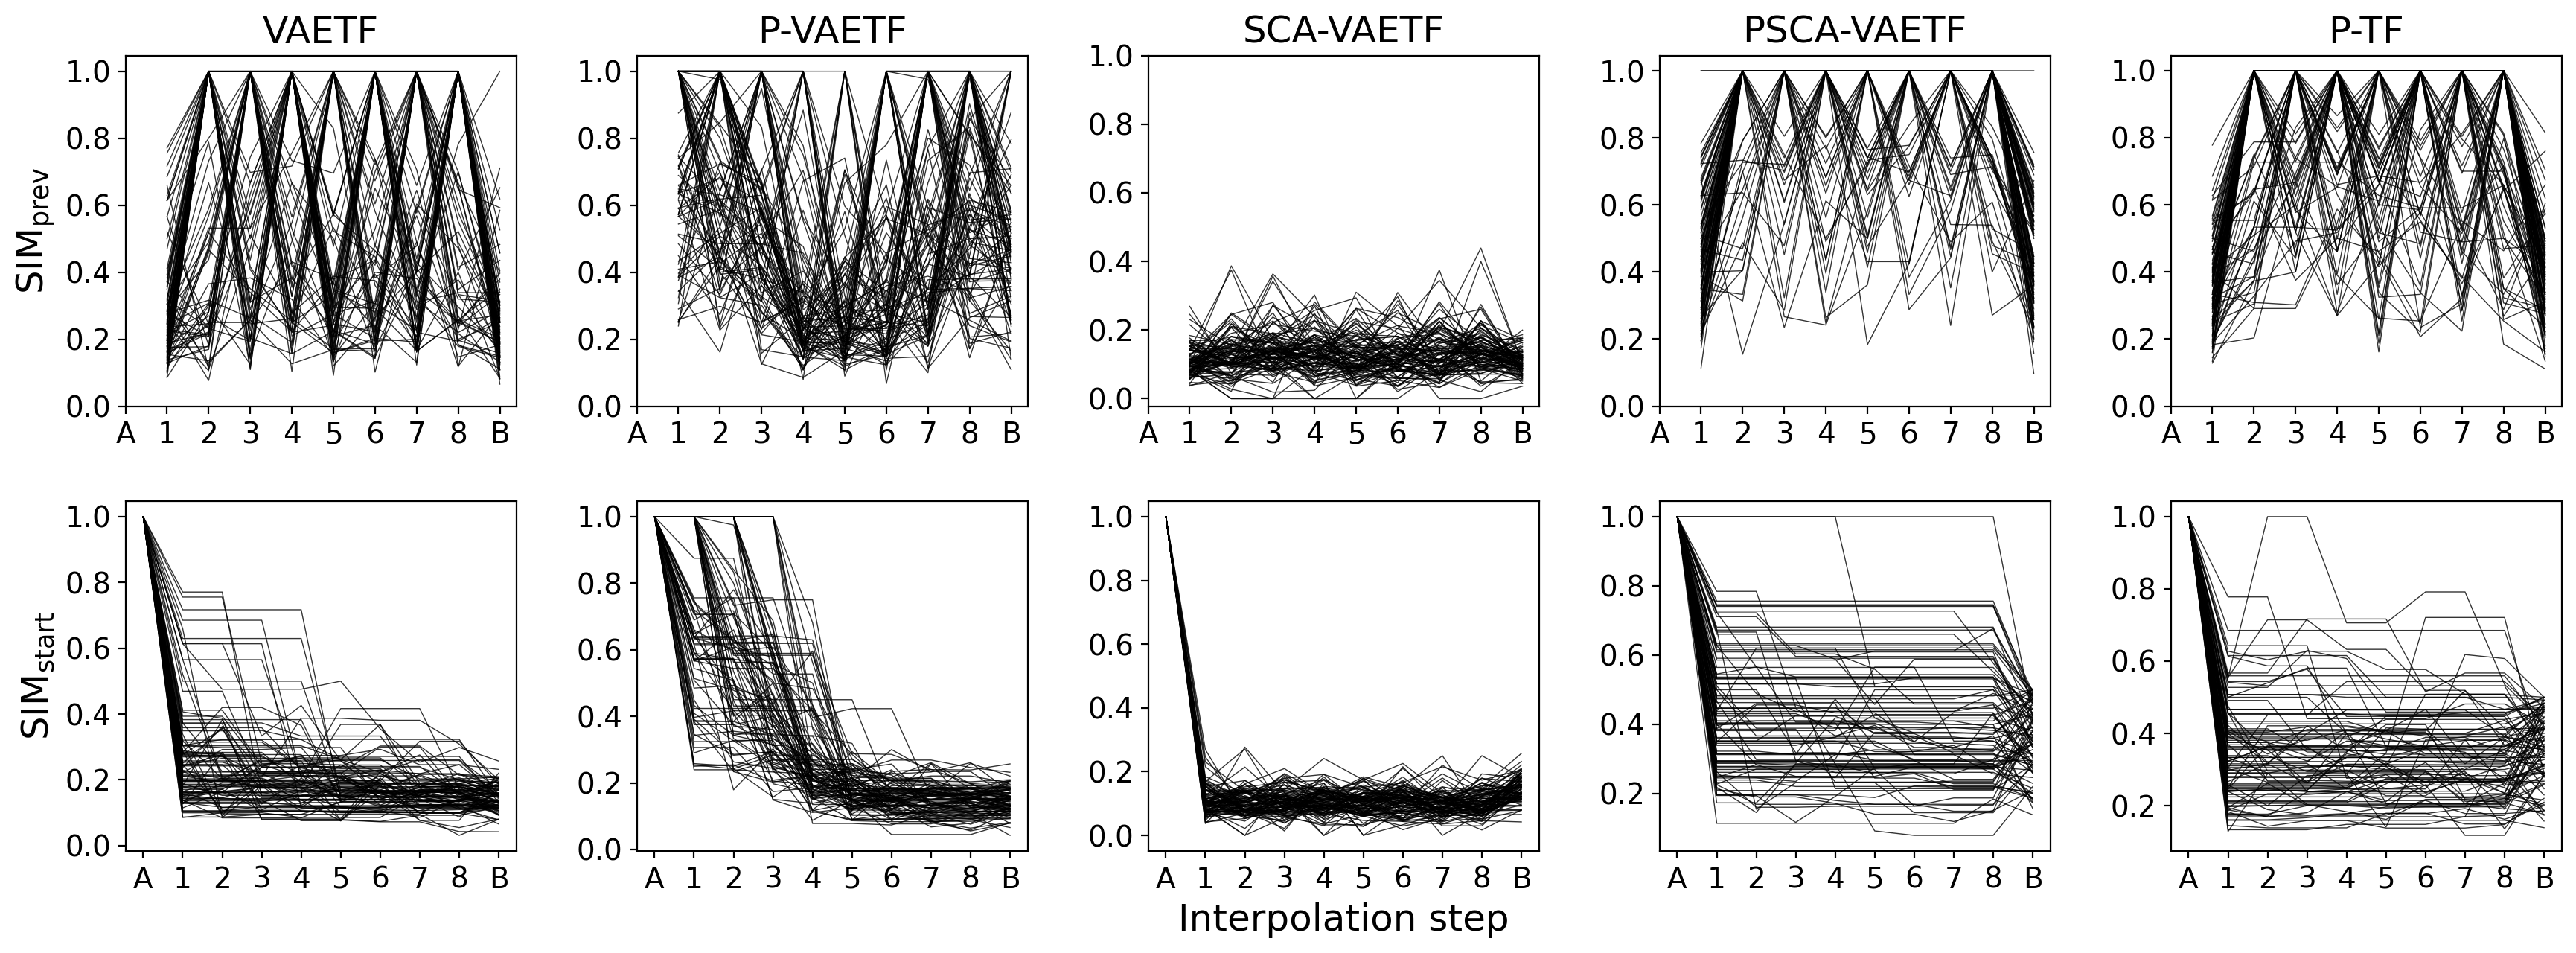

In [6]:
model_name = ['VAETF', 'P-VAETF', 'SCA-VAETF', 'PSCA-VAETF', 'P-TF']


figsize = (17.5, 6.5)

fig, axes = plt.subplots(2, 5, dpi=200)
xticks = [i for i in range(10)]

for i, sim_prev in enumerate(sim_prev_list):
    ax = axes[0, i]

    ax = sim_prev.plot(figsize=figsize, use_index=True,
                       kind='line', color='black', legend=False,
                       alpha=0.8, ax=ax, linewidth=0.5)
    if i == 0:
        ax.set_ylabel(r'$\mathdefault{SIM}_{\mathdefault{prev}}$', fontsize=18)
    
    ax.set_title(model_name[i], fontsize=18)
    ax.set_xticks([i for i in range(10)])
    ax.set_xticklabels(['A', '1', '2', '3', '4', '5', '6', '7', '8', 'B'])

    ax.set_yticks(np.arange(0, 1+0.2, 0.2))

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)


for i, sim_prev in enumerate(sim_start_list):
    ax = axes[1, i]

    ax = sim_prev.plot(figsize=figsize, use_index=True,
                       kind='line', color='black', legend=False,
                       alpha=0.8, ax=ax, linewidth=0.5)
    if i == 0:
        ax.set_ylabel(r'$\mathdefault{SIM}_{\mathdefault{start}}$', fontsize=18)
    if i == 2:
        ax.set_xlabel('Interpolation step', fontsize=18)

    ax.set_xticks([i for i in range(10)])
    ax.set_xticklabels(['A', '1', '2', '3', '4', '5', '6', '7', '8', 'B'])
    
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

plt.tight_layout(h_pad=2.5, w_pad=2)